# Classification: Instant Recognition with Caffe

In this example we'll classify an image with the vgg_dicenet model (which is based on the network architecture of Jaderberg et al. in NIPS 2014). It is a very large convolutional neural network to perform word recognition on pre-segmented word images. The network is trained solely on data produced by a synthetic text generation engine, requiring no human labelled data.

We'll compare CPU and GPU modes and then dig into the model to inspect features and the output.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import time
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* Assume you have the vgg_dictnet.

In [3]:
import os
if os.path.isfile(caffe_root + 'data/vgg_data/dictnet_vgg.caffemodel'):
    print 'VGG Models found.'
else:
    print 'Downloading pre-trained VGG models...'
    !wget vgg_models.tar.gz -O https://www.dropbox.com/s/v1avmkm7q2i6d1e/vgg_models.tar.gz?dl=0
    !tar xvf vgg_models.tar.gz

VGG Models found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU or GPU mode and load the net from disk.

In [4]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
# caffe.set_mode_cpu()

model_def = caffe_root + 'data/vgg_data/dictnet_vgg_deploy.prototxt'
model_weights = caffe_root + 'data/vgg_data/dictnet_vgg.caffemodel'
print model_def
print model_weights

net = caffe.Net(model_def,      # defines the structure of the model#
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

../data/vgg_data/dictnet_vgg_deploy.prototxt
../data/vgg_data/dictnet_vgg.caffemodel


#### net.blobs
For input data and its propagation in the layers
(batch_size, channel_dim, height, width).

In [5]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 1, 32, 100)
conv1	(1, 64, 32, 100)
pool1	(1, 64, 16, 50)
conv2	(1, 128, 16, 50)
pool2	(1, 128, 8, 25)
conv3	(1, 256, 8, 25)
conv3_5	(1, 512, 8, 25)
pool3	(1, 512, 4, 13)
conv4	(1, 512, 4, 13)
fc1	(1, 4096, 1, 1)
fc2	(1, 4096, 1, 1)
fc_class	(1, 88172, 1, 1)
prob	(1, 88172, 1, 1)


#### net.params
* Weights: index `[0]`, `(output_channels, input_channels, filter_height, filter_width)`
* biases: index `[1]`, `(output_channels,)`

In [7]:
total_param = 0
for layer_name, param in net.params.iteritems():
    param_num = param[0].data.shape[0] * param[0].data.shape[1] * param[0].data.shape[2] * param[0].data.shape[3]
    param_num += param[1].data.shape[0]
    total_param += param_num
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape) + '\t' + str(param_num)
print 'Total Parameters: ' + str(total_param * 0.000001) + ' millions'
print 'Require Memory: ' + str(total_param * 0.000001) + ' GB'

conv1	(64, 1, 5, 5) (64,)	1664
conv2	(128, 64, 5, 5) (128,)	204928
conv3	(256, 128, 3, 3) (256,)	295168
conv3_5	(512, 256, 3, 3) (512,)	1180160
conv4	(512, 512, 3, 3) (512,)	2359808
fc1	(4096, 512, 4, 13) (4096,)	109056000
fc2	(4096, 4096, 1, 1) (4096,)	16781312
fc_class	(88172, 4096, 1, 1) (88172,)	361240684
Total Parameters: 491.119724 millions
Require Memory: 491.119724 GB


In [8]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension

### 3. Classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 1 to demonstrate batching.

In [9]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          1,         # 1-channel gray images
                          32, 100)  # image size is 32x100

* Load an image and perform the preprocessing we've set up.

In [ ]:


in_data = open('images/2016-06-28/output_files_poses_labels_list.txt','rb')
out_data = open('images/2016-06-28/all_predict.txt','wb')

count = 0
ts = time.time()
while True:
    content = in_data.readline()
    if content == "":
        break
    #read filename
    j = 0
    s = 0
    fg = 0
    while True:
        if fg == 0 and content[j] == ',':
            s = j +1
            fg = 1
        elif fg == 1 and content[j] == ',':
            break
        j = j + 1
    filename = content[s:j]
    print filename
    img_path = caffe_root + 'examples/images/2016-06-28/' + filename
    image_rgb = caffe.io.load_image(img_path)
    transformed_image = transformer.preprocess('data', image_rgb)
    plt.imshow(image_rgb)

    image = caffe.io.load_image(img_path, False)
    transformed_image = transformer.preprocess('data', image)
    # plt.imshow(image)

    # copy the image data into the memory allocated for the net
    net.blobs['data'].data[...] = transformed_image
    right_class = 0
    ### perform classification
    if content[0] == "0" and content[1] == "_":
        right_class = 52089
    elif content[0] == "1" and content[1] == "_":
        right_class = 71726
    elif content[0] == "2" and content[1] == "_":
        right_class = 6486
    elif content[0] == "3" and content[1] == "_":
        right_class = 49401
    elif content[0] == "4" and content[1] == "_":
        right_class = 40356
    elif content[0] == "5" and content[1] == "_":
        right_class = 43383
    elif content[0] == "6" and content[1] == "_":
        right_class = 17803
    elif content[0] == "7" and content[1] == "_":
        right_class = 14662
    elif content[0] == "8" and content[1] == "_":
        right_class = 3685
    elif content[0] == "9" and content[1] == "_":
        right_class = 48035
    elif content[0] == "1" and content[1] == "1":
        right_class = 41013     
    elif content[0] == "1" and content[1] == "2":
        right_class = 30822
    elif content[0] == "1" and content[1] == "4":
        right_class = 36105
    elif content[0] == "1" and content[1] == "5":
        right_class = 35242
    elif content[0] == "1" and content[1] == "6":
        right_class = 8094
    elif content[0] == "1" and content[1] == "8":
        right_class = 5356
    elif content[0] == "1" and content[1] == "9":
        right_class = 6486
    elif content[0] == "2" and content[1] == "0":
        right_class = 38122
    elif content[0] == "2" and content[1] == "2":
        right_class = 14980
    elif content[0] == "2" and content[1] == "3":
        right_class = 39995
    elif content[0] == "2" and content[1] == "4":
        right_class = 43602
    elif content[0] == "2" and content[1] == "5":
        right_class = 6106
    elif content[0] == "2" and content[1] == "6":
        right_class = 24518
    elif content[0] == "2" and content[1] == "7":
        right_class = 55898
    elif content[0] == "2" and content[1] == "8":
        right_class = 51196
    elif content[0] == "2" and content[1] == "9":
        right_class = 13048
    
    
    right_index=0
    
    output = net.forward()
    ans = output['prob'][0]
    print ans.argmax()
    
    first_prob = ans.argmax()
    ans[first_prob]=0
    
    if first_prob == right_class:
        right_index = 1        
    
    second_prob = ans.argmax()
    ans[second_prob]=0
    
    if second_prob == right_class:
        right_index = 2  
    
    third_prob = ans.argmax()
    ans[third_prob]=0
    
    if third_prob == right_class:
        right_index = 3  
    
    forth_prob = ans.argmax()
    ans[forth_prob]=0
    
    if forth_prob == right_class:
        right_index = 4  
    
    fifth_prob = ans.argmax()
    ans[fifth_prob]=0
    
    if fifth_prob == right_class:
        right_index = 5
    
    fg = 0
    if right_index == 0:
        fg = 1
        right_index = 5

    
#     while fg == 1:
#         right_index = right_index + 1
#         tmp = ans.argmax()
        
#         if tmp == right_class:
#             break
#         ans[tmp]=0
        
    
    
    
    

    # load ImageNet labels
    labels_file = caffe_root + 'models/vgg_dictnet/dictnet_vgg_labels.txt'
    if not os.path.exists(labels_file):
        print 'label file does not exist'

    labels = np.loadtxt(labels_file, str, delimiter='\t')
    print count
    out_data.write(content[:-1] + labels[first_prob].upper() + ','+ labels[second_prob].upper() + ',' + labels[third_prob].upper() +','+ labels[forth_prob].upper() +','+ labels[fifth_prob].upper() +'\n')
    count = count + 1
te = time.time()

out_data.close()
print "End!",str(te-ts)

* Let's also look at other top (but less confident predictions).

In [13]:
# sort top five predictions from softmax output
import heapq
top_inds = heapq.nlargest(3, range(len(output_prob)), output_prob.take)  # reverse sort and take five largest items
print top_inds

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

[23894, 49466, 16151]
probabilities and labels:


[(array([[  1.20096647e-05]], dtype=float32), 'xxi'),
 (array([[  1.19968663e-05]], dtype=float32), '1957'),
 (array([[  1.19438946e-05]], dtype=float32), 'ion')]

* We see that less confident predictions are sensible.

### 4. Switching to GPU mode

* Let's see how long classification took, and compare it to GPU mode.

In [14]:
%timeit net.forward()

10 loops, best of 3: 29.8 ms per loop


* That's a while, even for a batch of 50 images. Let's switch to GPU mode.

In [15]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 29.8 ms per loop


* That should be much faster!

### 5. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

In [16]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 1, 32, 100)
conv1	(1, 64, 32, 100)
pool1	(1, 64, 16, 50)
conv2	(1, 128, 16, 50)
pool2	(1, 128, 8, 25)
conv3	(1, 256, 8, 25)
conv3_5	(1, 512, 8, 25)
pool3	(1, 512, 4, 13)
conv4	(1, 512, 4, 13)
fc1	(1, 4096, 1, 1)
fc2	(1, 4096, 1, 1)
fc_class	(1, 88172, 1, 1)
prob	(1, 88172, 1, 1)


In [17]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(64, 1, 5, 5) (64,)
conv2	(128, 64, 5, 5) (128,)
conv3	(256, 128, 3, 3) (256,)
conv3_5	(512, 256, 3, 3) (512,)
conv4	(512, 512, 3, 3) (512,)
fc1	(4096, 512, 4, 13) (4096,)
fc2	(4096, 4096, 1, 1) (4096,)
fc_class	(88172, 4096, 1, 1) (88172,)


* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [18]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* First we'll look at the first layer filters, `conv1`

TypeError: Invalid dimensions for image data

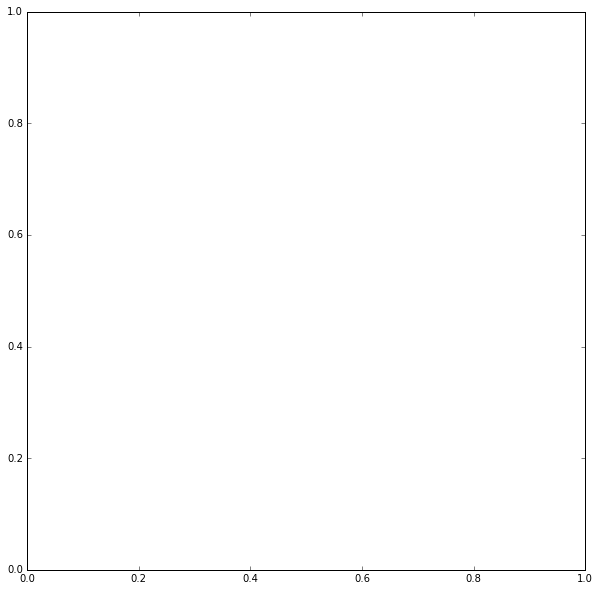

In [19]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

* The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

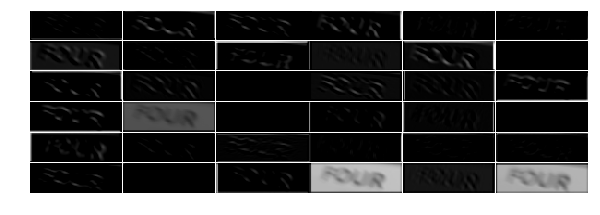

In [20]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

* The fifth layer after pooling, `pool5`

In [21]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

KeyError: 'pool5'

* The first fully connected layer, `fc6` (rectified)

    We show the output values and the histogram of the positive values

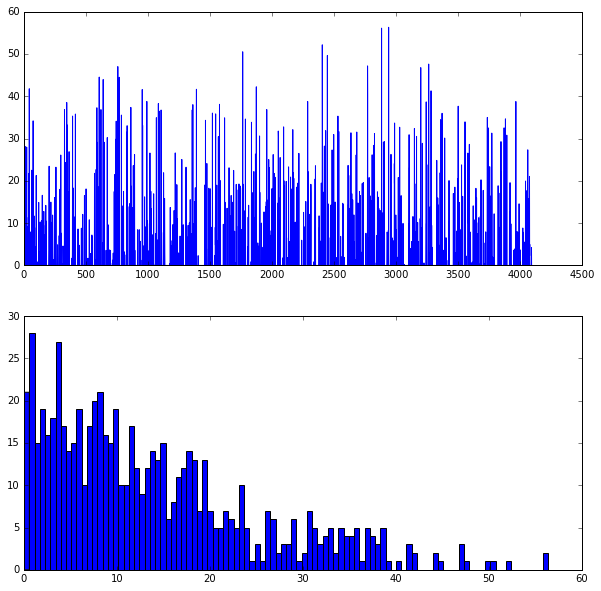

In [19]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

* The final probability output, `prob`

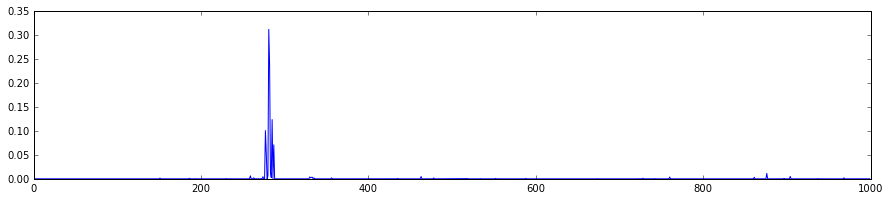

In [20]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

### 6. Try your own image

Now we'll grab an image from the web and classify it using the steps above.

* Try setting `my_image_url` to any JPEG image URL.